Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# Not fully comfortable with searches, we'll stick with train/val/test
from sklearn.model_selection import train_test_split
y_col = 'status_group'
train, val = train_test_split(train, stratify=train[y_col], random_state=143)

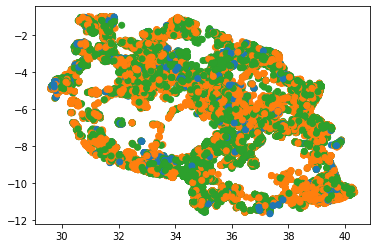

In [0]:
import numpy as np
from sklearn.decomposition import PCA

def wrangle(X):
  X = X.copy()
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, float('nan'))
    X[col+'_MISSING'] = X[col].isnull()
  for col in ['latitude', 'longitude']:
    si = SimpleImputer(strategy='median')
    X[col] = si.fit_transform(X[[col]])
  km = KMeans(n_clusters=7, random_state=143)
  km.fit(X[['latitude', 'longitude']])
  X['cluster'] = km.labels_
  duplicates = ['quantity_group', 'quality_group', 'payment_type',
                'extraction_type_group', 'region', 'source_type',
                'waterpoint_type_group']
  X = X.drop(columns=duplicates)
  unusable_variance = ['recorded_by', 'id', 'wpt_name', 'scheme_name']
  X = X.drop(columns=unusable_variance)
  no_variance = ['num_private']
  X = X.drop(columns=no_variance)
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()
  return X

train_w = wrangle(train)
val_w = wrangle(val)
test_w = wrangle(test)

groups = train_w[y_col].unique()
cmap = {
    'non functional': 'C1',
    'functional needs repair': 'C0',
    'functional': 'C2'
}
colors = [cmap[v] for v in train_w['status_group']]
plt.scatter(train_w['longitude'], train_w['latitude'], c=colors)
plt.show()

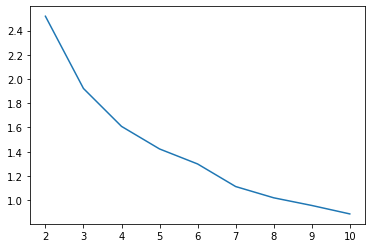

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
latlng = train_w[['longitude', 'latitude']]
si = SimpleImputer(strategy='median')
latlng = si.fit_transform(latlng)
distortions = []
for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=143)
  model.fit(latlng)
  distortions.append(sum(np.min(cdist(latlng, model.cluster_centers_, 'euclidean'), axis=1)) / latlng.shape[0])
plt.plot(range(2,11), distortions)
plt.show()

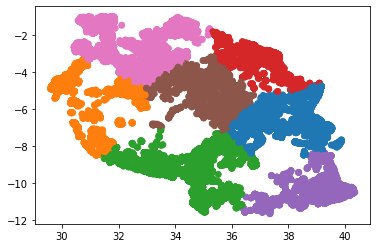

In [0]:
cmap = {i:f'C{i}' for i in range(7)}
colors = [cmap[_] for _ in train_w['cluster']]
plt.scatter(train_w['longitude'], train_w['latitude'], c=colors)
plt.show()

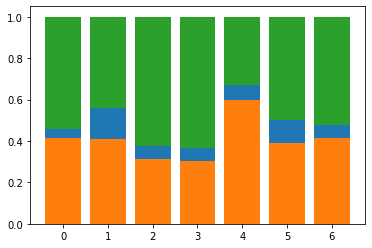

In [0]:
x = range(7)
yF = [train_w[train_w['cluster'] == _]['status_group'].value_counts(normalize=True)['functional'] for _ in x]
yFR = [train_w[train_w['cluster'] == _]['status_group'].value_counts(normalize=True)['functional needs repair'] for _ in x]
yNF = [train_w[train_w['cluster'] == _]['status_group'].value_counts(normalize=True)['non functional'] for _ in x]
yf = [yFR[i] + yNF[i] for i in range(len(yF))]

plt.bar(x, yNF, color='C1')
plt.bar(x, yFR, bottom=yNF, color='C0')
plt.bar(x, yF, bottom=yf, color='C2')
plt.show()

In [0]:
justtrain = train_w.drop(columns=y_col)
numfeats = justtrain.select_dtypes(include='number').columns.tolist()
cardinals = justtrain.select_dtypes(exclude='number').nunique()
catfeats = cardinals[cardinals <= 50].index.tolist()
X_cols = numfeats + catfeats
sorted(X_cols)

['amount_tsh',
 'basin',
 'cluster',
 'construction_year',
 'construction_year_MISSING',
 'day_recorded',
 'district_code',
 'extraction_type',
 'extraction_type_class',
 'gps_height',
 'gps_height_MISSING',
 'latitude',
 'latitude_MISSING',
 'longitude',
 'longitude_MISSING',
 'management',
 'management_group',
 'month_recorded',
 'payment',
 'permit',
 'population',
 'population_MISSING',
 'public_meeting',
 'quantity',
 'region_code',
 'scheme_management',
 'source',
 'source_class',
 'water_quality',
 'waterpoint_type',
 'year_recorded',
 'years',
 'years_MISSING']

In [0]:
X_train = train_w[X_cols]
X_val = val_w[X_cols]
X_test = test_w[X_cols]
y_train = train_w[y_col]
y_val = val_w[y_col]

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=143)
)

pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.9935353535353535

In [0]:
y_pred = pipeline.predict(X_test)
df = pd.DataFrame({'id':test['id'],'status_group':y_pred})
df.to_csv('submission6.csv', index=False)
df.shape

(14358, 2)